In [37]:
from glob import glob
import time
import json
import os
import shutil 

import numpy as np

import pystac_client
import planetary_computer
import geopandas as gpd
import stackstac

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio import plot
import rioxarray 

import matplotlib
import matplotlib.pyplot as plt
import shapely
import src.height_estimation as he

In [3]:
def getFeatures(gdf): #used
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [4]:
def write_raster(raster, img, transform, count, path):
    out_meta = raster.meta
    out_meta.update({"driver": "GTiff", "height": img.shape[1],
                     "width": img.shape[2], "transform": transform,
                    "count": count})
    with rasterio.open(path, "w", **out_meta) as dest:
        dest.write(img)

In [5]:
collection="3dep-lidar-hag" 
all_tiles_dir="/hpc/group/borsuklab/ast/tiles"
tif_name = 'm_3009354_sw_15_060_20190905.tif'

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier = planetary_computer.sign_inplace,)

#create utm geometry
#minx, miny, maxx, maxy = row[['nw_x_utm_object_coord','se_y_utm_object_coord',
#                              'se_x_utm_object_coord','nw_y_utm_object_coord']]
tank_geometry_latlon = shapely.geometry.box(-93.3446, 30.158, -93.315665, 30.186935, ccw=True) #utm
#search catalog using lat lon geometry
item_collection = catalog.search(collections=[collection], 
                        intersects=tank_geometry_latlon).item_collection()


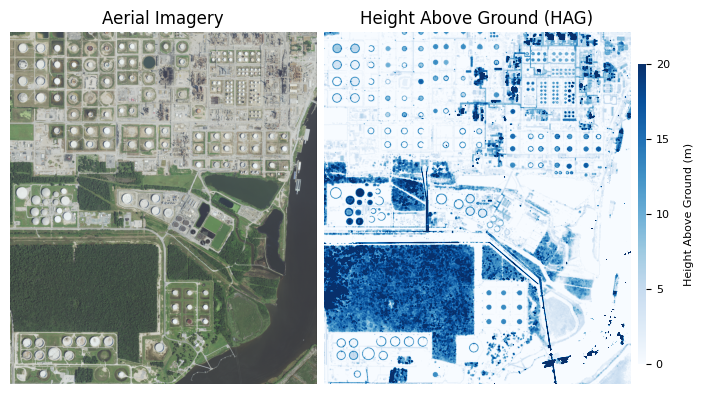

In [5]:
tank_geometry_utm = shapely.geometry.box(467_000.0, 3_336_342.0, 469_400.0, 3_339_100.0, ccw=True) #u

tif_raster = rasterio.open(os.path.join(all_tiles_dir, tif_name))
geo = gpd.GeoDataFrame({'geometry': tank_geometry_utm}, index=[0], crs=tif_raster.crs)     
tif_img, tif_transform  = rasterio.mask.mask(dataset=tif_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

hag_raster = rasterio.open(item_collection[0].assets["data"].href)#.read().squeeze()
hag_img, hag_transform  = rasterio.mask.mask(dataset=hag_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
rasterio.plot.show(tif_img[:3].squeeze(), transform=tif_transform, ax=axes[0], zorder=0) 
axes[0].set_axis_off()
axes[0].set_title(f"Aerial Imagery",fontsize=12)
#axes[0].set_aspect("equal")
axes[0].set_aspect('equal', 'box')

axes[1].imshow(hag_img.squeeze(), cmap="Blues", vmin=0, vmax=20)
axes[1].set_axis_off()
axes[1].set_title(f"Height Above Ground (HAG)",fontsize=12)
#axes[1].set_aspect("equal")
axes[1].set_aspect('equal', 'box')


sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=20)) 
sm._A = []
ax_cbar = plt.gcf().add_axes([0.91, 0.3, 0.01, 0.375]) #[xmin, ymin, dx, dy]  
cbar = plt.gcf().colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('Height Above Ground (m)',labelpad=10, fontsize=8)# y=0.45)
cbar.set_ticks([0, 5, 10, 15, 20])
cbar.set_ticklabels([0, 5, 10, 15, 20], fontsize=8)
cbar.outline.set_visible(False)
    
    
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()
fig.savefig("HAG.png", dpi=900, pad_inches=0.25)

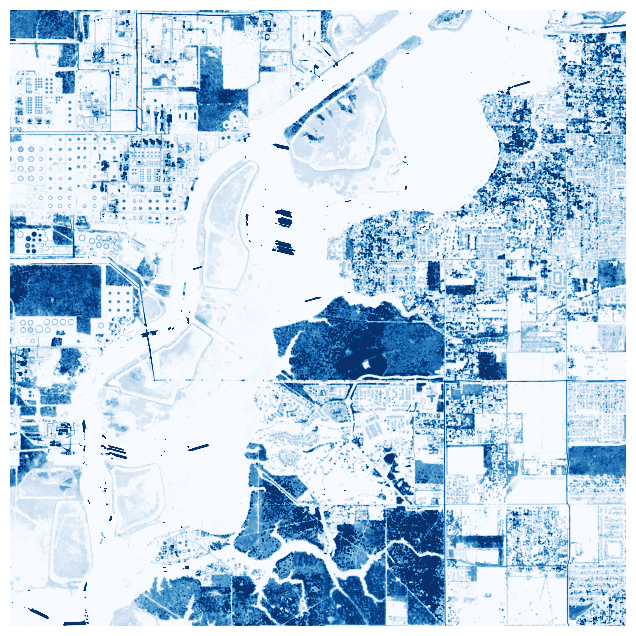

In [18]:
hag_raster = rasterio.open(item_collection[0].assets["data"].href).read()#.squeeze()
#hag_img, hag_transform  = rasterio.mask.mask(dataset=hag_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
rasterio.plot.show(hag_raster, cmap="Blues", vmin=0, vmax=20, ax=axes)
axes.set_axis_off()
axes.set_xticks([])
axes.set_yticks([])

plt.axis('off')

plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()
fig.savefig("HAG_alone.jpg", dpi=900, pad_inches=0.25)

In [6]:
write_raster(hag_raster, hag_img, hag_transform, 1, "/hpc/home/csr33/hag.tif")
write_raster(tif_raster, tif_img[:3], tif_transform, 3, "/hpc/home/csr33/ast_object_detection/tif.tif")

In [7]:
compiled_predicted_tank = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/compiled_predicted_tank.geojson")

In [8]:
compiled_predicted_tank[compiled_predicted_tank.tile_names == os.path.splitext(tif_name)[0]]

,confidence,object_class,tile_names,diameter,utm_proj,height,id,capacity,geometry


In [9]:
tiles = os.listdir("/hpc/group/borsuklab/csr33/object_detection/naip_tiles/")

In [39]:
from ultralytics import YOLO
import cv2

#search catalog using lat lon geometry
import pyproj 
from pyproj import Proj
import shapely
from shapely.geometry import Point
from shapely.ops import transform

In [32]:
def plot_predictions_on_img(image, result, class_name_dict, box_colors):
    boxes = result.boxes
    for box in boxes:
        class_number = box.cls.cpu().detach().tolist()[0]
        class_name = class_name_dict[class_number]
        class_color = box_colors[int(class_number)]

        xmin, ymin, xmax, ymax = box.xyxy[0]  
        conf = box.conf.cpu().detach().tolist()[0]

        start_point = (int(xmin), int(ymin)) 
        end_point = (int(xmax), int(ymax))
        image = cv2.rectangle(image, start_point, end_point, color=class_color, thickness=2)
    return image

def format_class_names(result):
    class_name_dict = result.names
    for key, value in class_name_dict.items():
        class_name_dict[key] = value.replace('_', ' ')
    return(class_name_dict)

def get_utm_coords(pixel_coords, utmx, utmy):
    minx, miny, maxx, maxy = pixel_coords
    return [utmx[minx], utmy[miny], utmx[maxx], utmy[maxy]]  

def transform_point_utm_to_wgs84(utm_proj, utm_xcoord, utm_ycoord): #used
    """ Convert a utm pair into a lat lon pair 
    Args: 
    utm_proj(str): the UTM string as the in term of EPSG code
    utmx(int): the x utm coordinate of a point
    utmy(int): the y utm coordinates of a point
    Returns: 
    (wgs84_pt.x, wgs84_pt.y): the 'EPSG:4326' x and y coordinates 
    """
    #https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects
    #get utm projection
    utm = pyproj.CRS(utm_proj)
    #get wgs84 proj
    wgs84 = pyproj.CRS('EPSG:4326')
    #specify utm point
    utm_pt = Point(utm_xcoord, utm_ycoord)
    #transform utm into wgs84 point
    project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
    wgs84_pt = transform(project, utm_pt)
    return wgs84_pt.x, wgs84_pt.y

def get_lat_lon_coords(utm_coords, utm_proj):
    minx, miny, maxx, maxy = utm_coords
    #determine the lat/lon
    nw_lon, nw_lat = transform_point_utm_to_wgs84(utm_proj, minx, miny)
    se_lon, se_lat = transform_point_utm_to_wgs84(utm_proj, maxx, maxy) 
    return [nw_lon, nw_lat, se_lon, se_lat]

In [12]:
box_colors = [(255, 0, 124, 0.8),(132, 0, 255, 0.8),(0, 60, 255, 0.8)]

In [25]:
img_path = "/hpc/group/borsuklab/csr33/object_detection/imgs/m_4007431_nw_18_060_20211105_06_09.jpg"
tif_path = "/hpc/group/borsuklab/csr33/object_detection/naip_tiles/m_4007431_nw_18_060_20211105.tif"

In [14]:
model_path="/work/csr33/object_detection/runs/detect/train_w_tuned_hyperparameters3/weights/best.pt"
model = YOLO(model_path)

In [35]:
x=9
y=6
item_dim=640
coords_yy_xx = [y*item_dim,y*item_dim+item_dim, x*(item_dim),x*(item_dim)+item_dim]

NameError: name 'utm_coords' is not defined

In [41]:
tif.y[coords_yy_xx[0]:coords_yy_xx[1]]
utm_coords = [tif.x[coords_yy_xx[2]].values.tolist(), tif.y[coords_yy_xx[0]].values.tolist(),
 tif.x[coords_yy_xx[3]].values.tolist(),tif.y[coords_yy_xx[1]].values.tolist()]
latlon_coords = get_lat_lon_coords(utm_coords, tif.rio.crs)
latlon_coords

[-74.21288634259739, 40.60711857949979, -74.20838852602644, 40.60362848896703]

In [26]:
tif = rioxarray.open_rasterio(tif_path)
sample_img = tif.data[0, coords_yy_xx[0]:coords_yy_xx[1], coords_yy_xx[2]:coords_yy_xx[3]]
image = cv2.imread(img_path)

NameError: name 'cv2' is not defined


image 1/1 /hpc/group/borsuklab/csr33/object_detection/imgs/m_4007431_nw_18_060_20211105_06_09.jpg: 640x640 13 closed_roof_tanks, 4716.0ms
Speed: 63.4ms preprocess, 4716.0ms inference, 269.9ms postprocess per image at shape (1, 3, 640, 640)


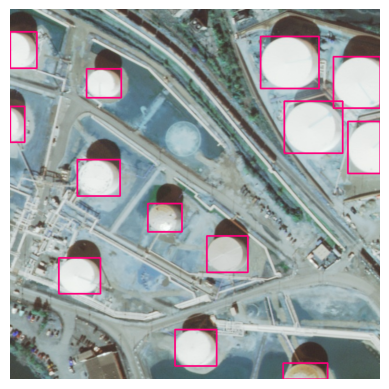

In [17]:
#plot predicted image
result = model(img_path, conf=0.5)  # results list
class_name_dict = format_class_names(result[0])
pred_image = plot_predictions_on_img(image, result[0], class_name_dict, box_colors)

fig, ax = plt.subplots()
ax.imshow(pred_image)
ax.set_axis_off()

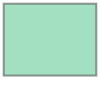

In [18]:
collection="3dep-lidar-hag" 
utm_coords = [tif.x[coords_yy_xx[2]].values.tolist(),tif.y[coords_yy_xx[0]].values.tolist(),
             tif.x[coords_yy_xx[3]].values.tolist(),tif.y[coords_yy_xx[1]].values.tolist()]
tank_geometry_utm = shapely.geometry.box(*utm_coords, ccw=True) #u
geo = gpd.GeoDataFrame({'geometry': tank_geometry_utm}, index=[0], crs=tif.rio.crs)     


latlon_coords = get_lat_lon_coords(utm_coords, tif.rio.crs)
tank_geometry_latlon = shapely.geometry.box(*latlon_coords, ccw=True) #utm

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier = planetary_computer.sign_inplace,)

item_collection = catalog.search(collections=[collection], 
                                 intersects=tank_geometry_latlon).item_collection()

hag_raster = rasterio.open(item_collection[0].assets["data"].href)#.read().squeeze()
hag_img, hag_transform  = rasterio.mask.mask(dataset=hag_raster, shapes=getFeatures(geo), 
                                             crop=True,nodata=255) 

hag_img = hag_img.astype(np.uint8)
with rasterio.open('/hpc/home/csr33/hag_img.tif', 'w', driver='GTiff', 
                height=hag_img.shape[1], width=hag_img.shape[2], 
                count=1, dtype=str(hag_img.dtype), 
                crs=hag_raster.crs, transform=hag_transform) as dst:
    dst.write(hag_img)
hag_raster.close()

In [20]:
geo

NameError: name 'geo' is not defined

In [19]:
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib import patches

In [23]:
box_colors_norm = [(255/255, 0, 124/255, 0.8),(132/255, 0, 255/255, 0.8),(0, 60/255, 255/255, 0.8)]


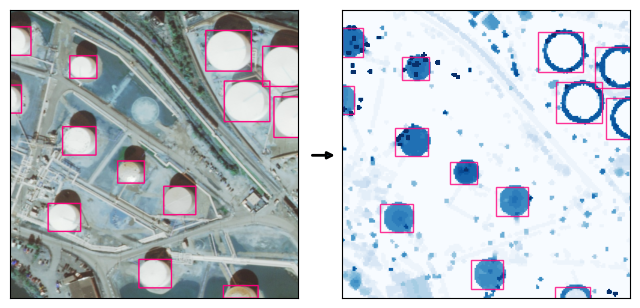

In [25]:
hag_raster = rasterio.open('/hpc/home/csr33/hag_img.tif')
hag_img = hag_raster.read()

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8,4))

axes[0].imshow(pred_image)
#axes[0].set_axis_off()
axes[0].set_xticks([]) 
axes[0].set_yticks([]) 
ax = axes[1]
#ax.add_patch(Rectangle((0.1, 0.1), 0.1, 0.1, fill=False, edgecolor='red', linewidth=2))
boxes = result[0].boxes
for box in boxes:
    class_number = box.cls.cpu().detach().tolist()[0]
    class_name = class_name_dict[class_number]
    class_color = box_colors_norm[int(class_number)]
    ten_box = box.xyxyn.cpu().detach()*192
    xmin, ymin, xmax, ymax = ten_box.tolist()[0]
    w = xmax - xmin
    h = ymax - ymin
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False,zorder=2, linewidth=1, edgecolor=class_color))
ax.imshow(hag_img.squeeze()[:192,:192], cmap="Blues", vmin=0, vmax=20, zorder=1)
#axes[1].set_axis_off()

con = ConnectionPatch(
    xyA = (-20,193/2), coordsA = axes[1].transData,
    xyB = (-5,193/2), coordsB = axes[1].transData,
    arrowstyle ="-|>")
con.set_linewidth(2)
axes[1].add_artist(con)
axes[1].set_xticks([]) 
axes[1].set_yticks([]) 
plt.subplots_adjust(wspace=0.15, hspace=0.1)

plt.show()
fig.savefig("/hpc/home/csr33/ast_object_detection/fig/predictions_to_height_estimation.jpg", dpi=900, pad_inches=0.2)

In [19]:
pred_image

NameError: name 'pred_image' is not defined